# Regularized Gradient Descent Using Spark

The goal of this project was to implement gradient descent for ols regression, with and without regularization, in a distributed fashion with PySpark. This data was made available through the UC Irvine public repository of Machine Learning datasets by researchers at the University of Minho in association with this paper:

P. Cortez, A. Cerdeira, F. Almeida, T. Matos and J. Reis. Modeling wine preferences by data mining from physicochemical properties. In Decision Support Systems, Elsevier, 47(4):547-553, 2009.

This dataset contains data on various features of portugese wines, as well as a numeric outcome variable - quality. The machine learning task is to predict quality from features that describe the wine such as color, acidity, and alcohol content. Through this project, I learned about the benefits of regularization and how ridge and lasso regression differ, while also practicing my skills coding in PySpark.

In [2]:
import re
import time
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import ast
import os
from pyspark.sql import SparkSession

## Spark and Data Setup

In [3]:
PWD = !pwd
PWD = PWD[0]

In [4]:
try:
    spark
except NameError:
    print('starting Spark')
    app_name = 'Lab6_notebook'
    master = "local[*]"
    spark = SparkSession\
            .builder\
            .appName(app_name)\
            .master(master)\
            .getOrCreate()
sc = spark.sparkContext

starting Spark
:: loading settings :: url = jar:file:/usr/lib/spark/jars/ivy-2.4.0.jar!/org/apache/ivy/core/settings/ivysettings.xml


Ivy Default Cache set to: /root/.ivy2/cache
The jars for the packages stored in: /root/.ivy2/jars
graphframes#graphframes added as a dependency
org.apache.spark#spark-avro_2.12 added as a dependency
:: resolving dependencies :: org.apache.spark#spark-submit-parent-105f884a-69dc-42dd-adee-9df6ff92a25d;1.0
	confs: [default]
	found graphframes#graphframes;0.8.2-spark3.1-s_2.12 in spark-packages
	found org.slf4j#slf4j-api;1.7.16 in central
	found org.apache.spark#spark-avro_2.12;3.1.3 in central
	found org.spark-project.spark#unused;1.0.0 in central
downloading https://repos.spark-packages.org/graphframes/graphframes/0.8.2-spark3.1-s_2.12/graphframes-0.8.2-spark3.1-s_2.12.jar ...
	[SUCCESSFUL ] graphframes#graphframes;0.8.2-spark3.1-s_2.12!graphframes.jar (57ms)
downloading https://repo1.maven.org/maven2/org/apache/spark/spark-avro_2.12/3.1.3/spark-avro_2.12-3.1.3.jar ...
	[SUCCESSFUL ] org.apache.spark#spark-avro_2.12;3.1.3!spark-avro_2.12.jar (23ms)
downloading https://repo1.maven.org/ma

In [6]:
!mkdir data
!wget -q -O data/reds.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv
!wget -q -O data/whites.csv http://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv

In [7]:
!ls -l data

total 344
-rw-r--r-- 1 root root  84199 Oct 16  2009 reds.csv
-rw-r--r-- 1 root root 264426 Oct 16  2009 whites.csv


In [8]:
!head data/reds.csv

"fixed acidity";"volatile acidity";"citric acid";"residual sugar";"chlorides";"free sulfur dioxide";"total sulfur dioxide";"density";"pH";"sulphates";"alcohol";"quality"
7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
7.8;0.88;0;2.6;0.098;25;67;0.9968;3.2;0.68;9.8;5
7.8;0.76;0.04;2.3;0.092;15;54;0.997;3.26;0.65;9.8;5
11.2;0.28;0.56;1.9;0.075;17;60;0.998;3.16;0.58;9.8;6
7.4;0.7;0;1.9;0.076;11;34;0.9978;3.51;0.56;9.4;5
7.4;0.66;0;1.8;0.075;13;40;0.9978;3.51;0.56;9.4;5
7.9;0.6;0.06;1.6;0.069;15;59;0.9964;3.3;0.46;9.4;5
7.3;0.65;0;1.2;0.065;15;21;0.9946;3.39;0.47;10;7
7.8;0.58;0.02;2;0.073;9;18;0.9968;3.36;0.57;9.5;7


In [13]:
DATA_BUCKET = os.getenv('DATA_BUCKET','')[:-1]
PROJECT_FOLDER = f"{DATA_BUCKET}/main/Assignments/Regularization/"

In [14]:
data_loc = f'{PROJECT_FOLDER}reds.csv'
!cat data/reds.csv | gsutil cp - {data_loc}   
data_loc = f'{PROJECT_FOLDER}whites.csv'
!cat data/whites.csv | gsutil cp - {data_loc}    

Copying from <STDIN>...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              
Copying from <STDIN>...
/ [1 files][    0.0 B/    0.0 B]                                                
Operation completed over 1 objects.                                              


In [16]:
header = !head -n 1 data/reds.csv
header = header[0]
FIELDS = ['color'] + re.sub('"', '', header).split(';')

In [20]:
data_loc = f'{PROJECT_FOLDER}reds.csv'
redsRDD = sc.textFile(data_loc)\
            .filter(lambda x: x != header)\
            .map(lambda x: '1;' + x) # set first field 1 to indicate red wine
data_loc = f'{PROJECT_FOLDER}whites.csv'
whitesRDD = sc.textFile(data_loc)\
              .filter(lambda x: x != header)\
              .map(lambda x: '0;' + x) # set first field 0 to indicate white wine
redsRDD.count(), whitesRDD.count()

22/10/15 23:41:10 WARN org.apache.hadoop.util.concurrent.ExecutorHelper: Thread (Thread[GetFileInfo #0,5,main]) interrupted: 
java.lang.InterruptedException
	at com.google.common.util.concurrent.AbstractFuture.get(AbstractFuture.java:510)
	at com.google.common.util.concurrent.FluentFuture$TrustedFuture.get(FluentFuture.java:88)
	at org.apache.hadoop.util.concurrent.ExecutorHelper.logThrowableFromAfterExecute(ExecutorHelper.java:48)
	at org.apache.hadoop.util.concurrent.HadoopThreadPoolExecutor.afterExecute(HadoopThreadPoolExecutor.java:90)
	at java.util.concurrent.ThreadPoolExecutor.runWorker(ThreadPoolExecutor.java:1157)
	at java.util.concurrent.ThreadPoolExecutor$Worker.run(ThreadPoolExecutor.java:624)
	at java.lang.Thread.run(Thread.java:750)
22/10/15 23:41:10 WARN org.apache.hadoop.util.concurrent.ExecutorHelper: Thread (Thread[GetFileInfo #1,5,main]) interrupted: 
java.lang.InterruptedException
	at com.google.common.util.concurrent.AbstractFuture.get(AbstractFuture.java:510)
	at c

(1599, 4898)

In [21]:
#train test split
trainRDD, heldOutRDD = redsRDD.union(whitesRDD).randomSplit([0.8,0.2], seed = 1)

In [22]:
#parses into tuple of fields
def parse(line):
    fields = np.array(line.split(';'), dtype = 'float')
    features,quality = fields[:-1], fields[-1]
    return(features, quality)

In [23]:
#cache the training data set
trainRDDCached = trainRDD.map(parse).cache()

## Exploratory Data Analysis

In [29]:
#took a sample of the data to perform exploratory data analysis on

sample = np.array(trainRDDCached.map(lambda x: np.append(x[0], [x[1]]))
                                .takeSample(False, 1000))
eda_df = pd.DataFrame(np.array(sample), columns = FIELDS)

In [30]:
eda_df

,color,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,0.0,8.2,0.680,0.30,2.10,0.047,17.0,138.0,0.99500,3.22,0.71,10.8,4.0
1,1.0,7.8,0.530,0.01,1.60,0.077,3.0,19.0,0.99500,3.16,0.46,9.8,5.0
2,1.0,7.6,0.665,0.10,1.50,0.066,27.0,55.0,0.99655,3.39,0.51,9.3,5.0
3,0.0,6.5,0.430,0.28,12.00,0.056,23.0,174.0,0.99860,3.31,0.55,9.3,5.0
4,0.0,6.3,0.230,0.22,3.75,0.039,37.0,116.0,0.99270,3.23,0.50,10.7,6.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,6.6,0.300,0.25,8.00,0.036,21.0,124.0,0.99362,3.06,0.38,10.8,6.0
996,1.0,10.0,0.690,0.11,1.40,0.084,8.0,24.0,0.99578,2.88,0.47,9.7,5.0
997,0.0,5.5,0.240,0.32,8.70,0.060,19.0,102.0,0.99400,3.27,0.31,10.4,5.0
998,0.0,5.6,0.390,0.24,4.70,0.034,27.0,77.0,0.99060,3.28,0.36,12.7,5.0


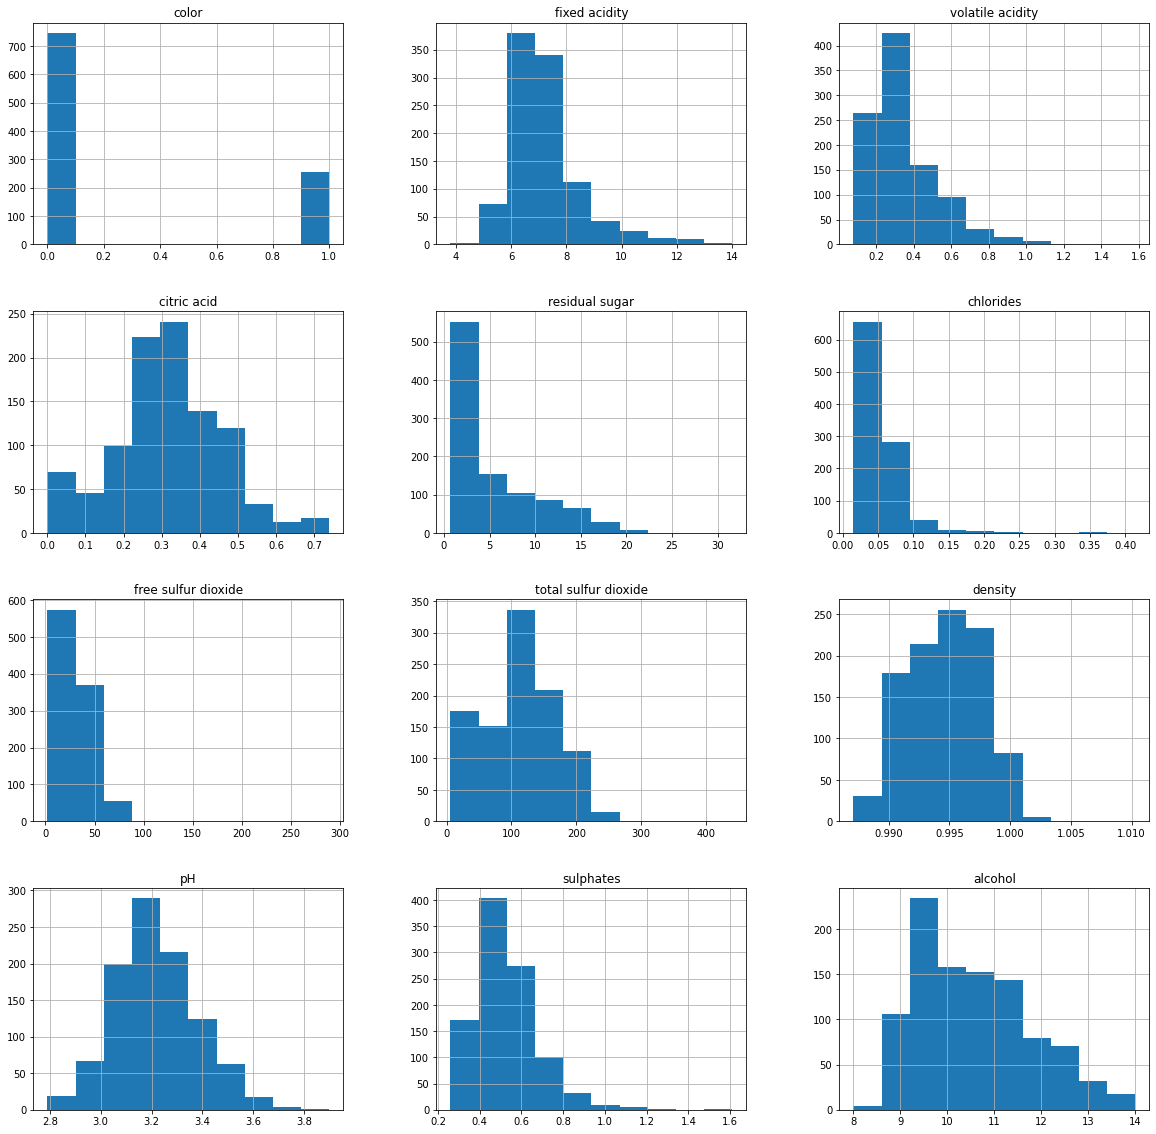

In [32]:
eda_df[FIELDS[:-1]].hist(figsize = (20,20))
plt.show()

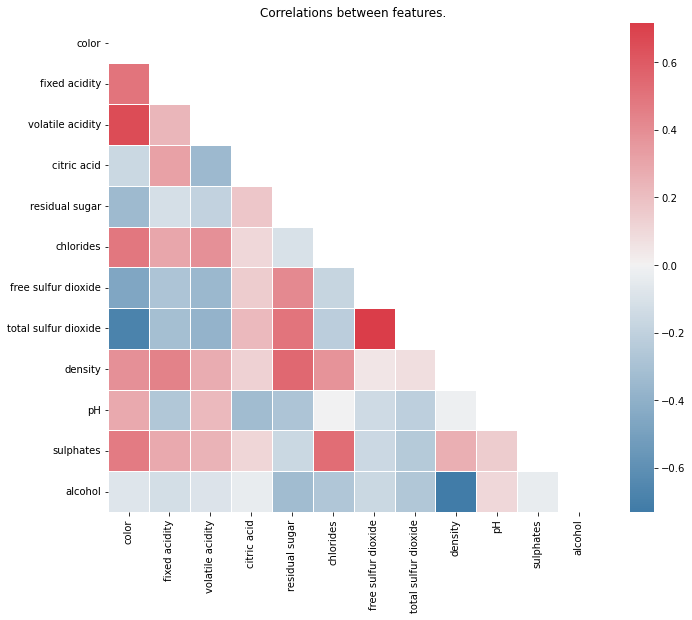

In [33]:
corr = sample_df[FIELDS[:-1]].corr()
fig, ax = plt.subplots(figsize=(11, 9))
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(240, 10, as_cmap=True)
sns.heatmap(corr, mask=mask, cmap=cmap, center=0, linewidths=.5)
plt.title("Correlations between features.")
plt.show()

## Feature Scaling

Here we scale features so that we can effectively apply gradient descent.

In [34]:
#scale and center data around the mean of each feature

def normalize(dataRDD):
    featureMeans = dataRDD.map(lambda x: x[0]).mean()
    featureStdev = np.sqrt(dataRDD.map(lambda x: x[0]).variance())
    
    normedRDD = dataRDD.map(lambda x:((x[0]-featureMeans)/featureStdev,x[1]))
    
    return normedRDD

In [35]:
normedRDD = normalize(trainRDDCached).cache()

In [36]:
#here is an example of what is in the RDD that we are working with

normedRDD.collect()[0]

(array([ 1.74033657,  0.15183907,  2.16064538, -2.17933445, -0.74196584,
         0.55362064, -1.09341301, -1.44586339,  1.039065  ,  1.81575205,
         0.19678311, -0.91099282]),
 5.0)

## Implementation of Gradient Descent without Regularization

In this section, we implement Gradient descent for standard ols regression. We save the model parameters and the loss history from each model for analysis and visualization later. 

In [37]:
#function that returns mean squared error

def OLSLoss(dataRDD, W):
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    loss = augmentedData.map(lambda x: (x[1] - np.dot(x[0],W))**2).mean()
    return loss

In [39]:
# function that performs a gradient descent update step given a dataRDD(features,y) and W(array of model coefficients). returns updated coefficients
def GDUpdate(dataRDD, W, learningRate = 0.1):    
    # add a bias 'feature' of 1 at index 0
    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1])).cache()
    grad = augmentedData.map(lambda x:(np.dot(x[0],W)-x[1])*x[0]).mean() * 2
    new_model = W - (learningRate*grad)
    return new_model

In [40]:
#performs nSteps of Gradient Descent

def GradientDescent(trainRDD, testRDD, wInit, nSteps = 20, learningRate = 0.1):
    
    train_history, test_history, model_history = [], [], []
    
    # perform n updates & compute test and train loss after each
    model = wInit
    for idx in range(nSteps): 
        
        
        model = GDUpdate(trainRDD, model)
        training_loss = OLSLoss(trainRDD, model)
        test_loss = OLSLoss(testRDD, model)
        
        
        train_history.append(training_loss)
        test_history.append(test_loss)
        model_history.append(model)
        
    return train_history, test_history, model_history

In [41]:
#defining a baseline model as the mean quality of wine

meanQuality = trainRDDCached.map(lambda x:x[1]).mean()
BASELINE = np.append(meanQuality,np.zeros(12))

In [88]:
# run gradient descent for ordinary least squares regression
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 2018)
MSEtrain, MSEtest, models = GradientDescent(trainRDD, testRDD, wInit, nSteps = 50)

In [44]:
#function to look at loss curves after running gradient descent

def plotErrorCurves(trainLoss, testLoss, title = None):
    
    fig, ax = plt.subplots(1,1,figsize = (16,8))
    x = list(range(len(trainLoss)))[1:]
    ax.plot(x, trainLoss[1:], 'k--', label='Training Loss')
    ax.plot(x, testLoss[1:], 'r--', label='Test Loss')
    ax.legend(loc='upper right', fontsize='x-large')
    plt.xlabel('Number of Iterations')
    plt.ylabel('Mean Squared Error')
    if title:
        plt.title(title)
    display(plt.show())

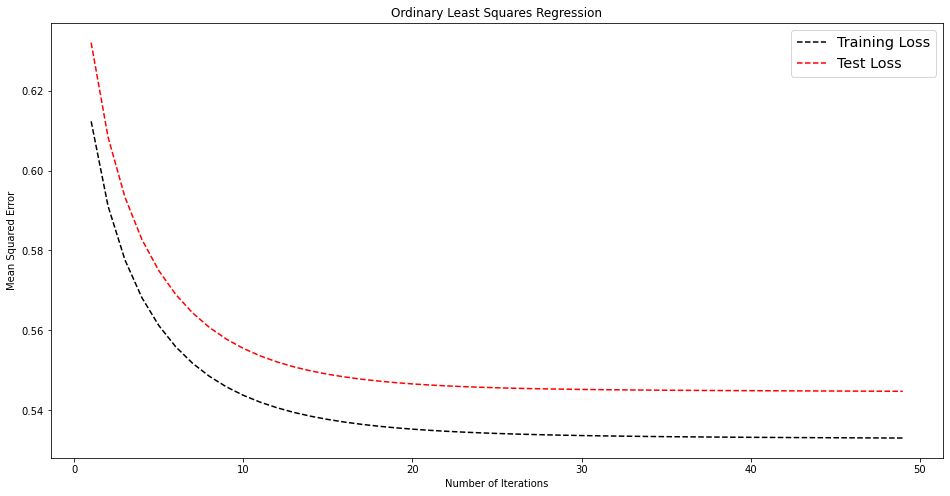

None

In [49]:
plotErrorCurves(MSEtrain, MSEtest, title = 'Ordinary Least Squares Regression')

## Gradient Descent with Regularization

In this section, we implement Gradient descent for ridge regression and lasso regression. We save the model parameters and the loss history from each model for analysis and visualization later. 

In [50]:
#gradient descent update step with regularization. takes in dataRDD(features,label), W(array of model coefficients),learning rate, and regularization type.
#returns updated coefficients

def GDUpdate_wReg(dataRDD, W, learningRate = 0.1, regType = None, regParam = 0.1):

    augmentedData = dataRDD.map(lambda x: (np.append([1.0], x[0]), x[1]))
    new_model = None
    grad = augmentedData.map(lambda x:(np.dot(x[0],W)-x[1])*x[0]).mean() * 2
    
    if(regType == 'ridge'):
        w_prime = np.copy(W)
        w_prime[0] = 0
        grad = grad + (2*(learningRate*w_prime))

    if(regType == 'lasso'):
        w_prime = np.copy(W)
        w_prime[0] = 0
        grad = grad + (learningRate * np.sign(w_prime))
     
    new_model = W - (learningRate*grad)
    

    return new_model

In [51]:
#performs nsteps of gradient descent with regularization. returns loss history as well as model coefficient history

def GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 20, learningRate = 0.1,
                         regType = None, regParam = 0.1, verbose = False):
 
    train_history, test_history, model_history = [], [], []
    model = wInit
    
    for idx in range(nSteps):  
       
        model = GDUpdate_wReg(trainRDD, model, learningRate, regType, regParam)
        
        
        train_history.append(OLSLoss(trainRDD, model))
        test_history.append(OLSLoss(testRDD, model))
        model_history.append(model)
        
    return train_history, test_history, model_history

### Ridge Regression

In [54]:
#run gradient descent with for ridge regression (ridge regularization)
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 2018)
ridge_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50, 
                                     regType='ridge', regParam = 0.05 )

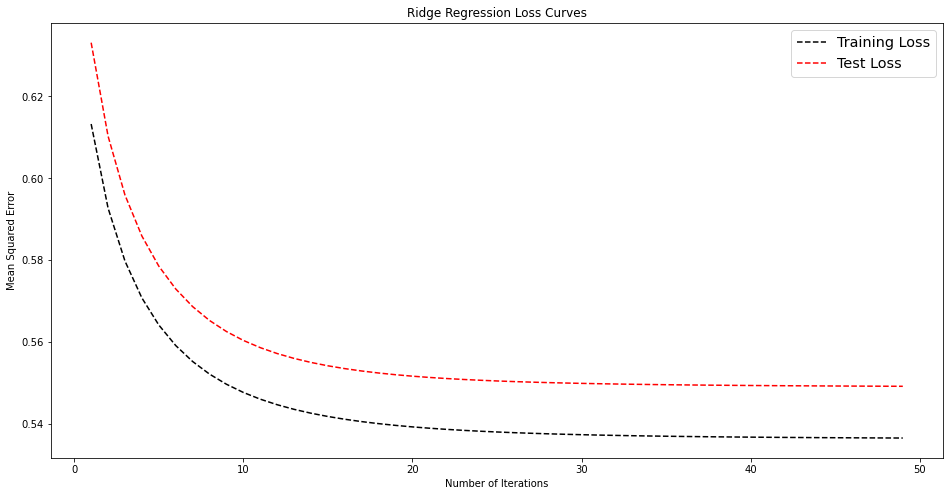

None

In [89]:
trainLoss, testLoss, ridge_models = ridge_results
plotErrorCurves(trainLoss, testLoss, title = 'Ridge Regression Loss Curves' )

### Lasso Regression

In [62]:
wInit = BASELINE
trainRDD, testRDD = normedRDD.randomSplit([0.8,0.2], seed = 2018)
lasso_results = GradientDescent_wReg(trainRDD, testRDD, wInit, nSteps = 50,
                                     regType='lasso', regParam = 0.05)

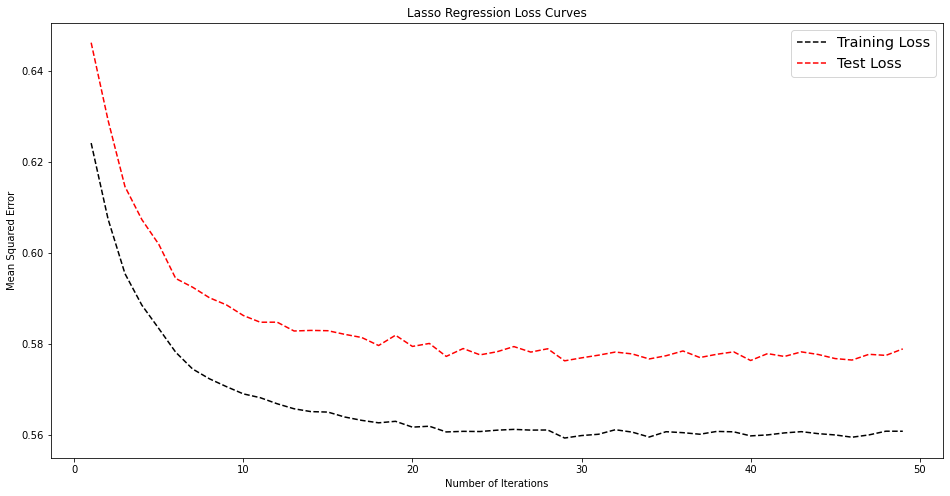

None

In [90]:
trainLoss, testLoss, lasso_models = lasso_results
plotErrorCurves(trainLoss, testLoss, title = 'Lasso Regression Loss Curves' )

## Comparison of Model Coefficients As the Model Trains

In this section, we visualize how the coefficients change using each type of regression across the 50 training steps of gradient descent.

In [110]:
#function that plots model coefficients as training occurs

def plotCoeffs(models, featureNames, title):
    
    fig, ax = plt.subplots(figsize = (15,8))
    X = list(range(len(models)))
    for data,name in zip(np.stack(models, axis=1 ),['Bias']+FIELDS[:-1]):
        if name == "Bias":
            continue
        ax.plot(X, data, label=name)
    ax.plot(X,[0]*len(X), 'k--')
    plt.title(title)
    plt.legend()
    display(plt.show())

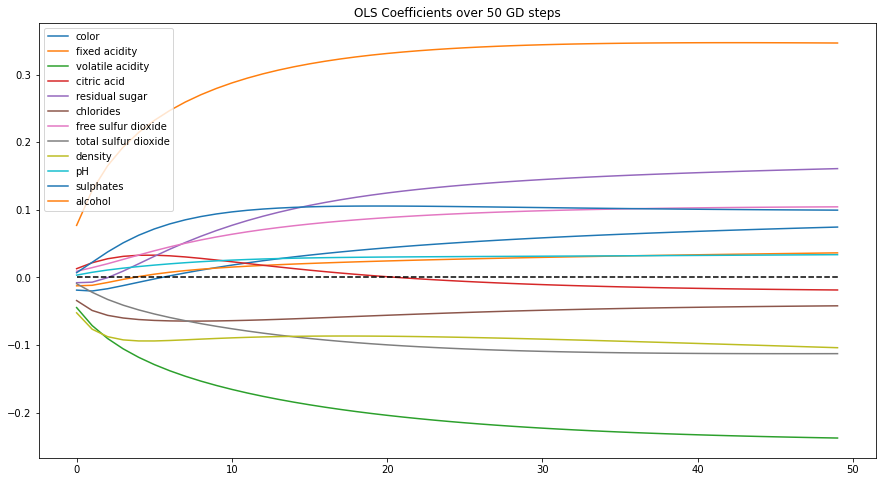

None

In [111]:
plotCoeffs(models, ['Bias'] + FIELDS, "OLS Coefficients over 50 GD steps")

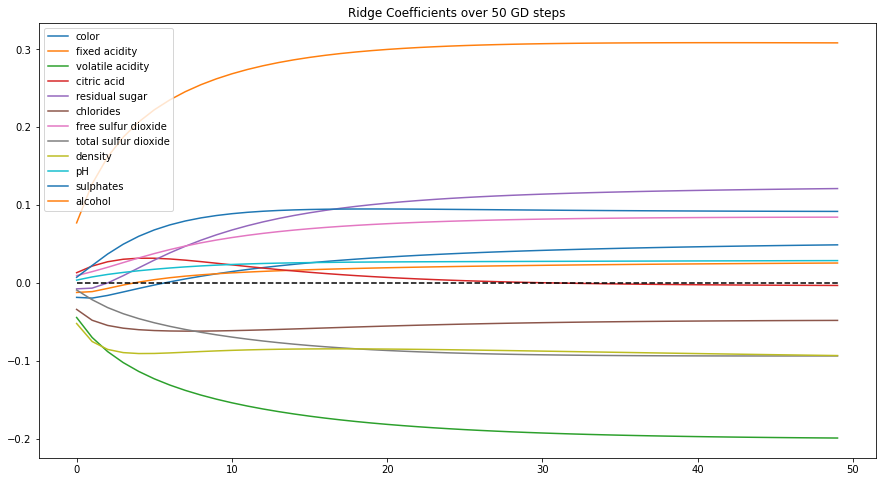

None

In [112]:
plotCoeffs(ridge_models, ['Bias'] + FIELDS, "Ridge Coefficients over 50 GD steps")

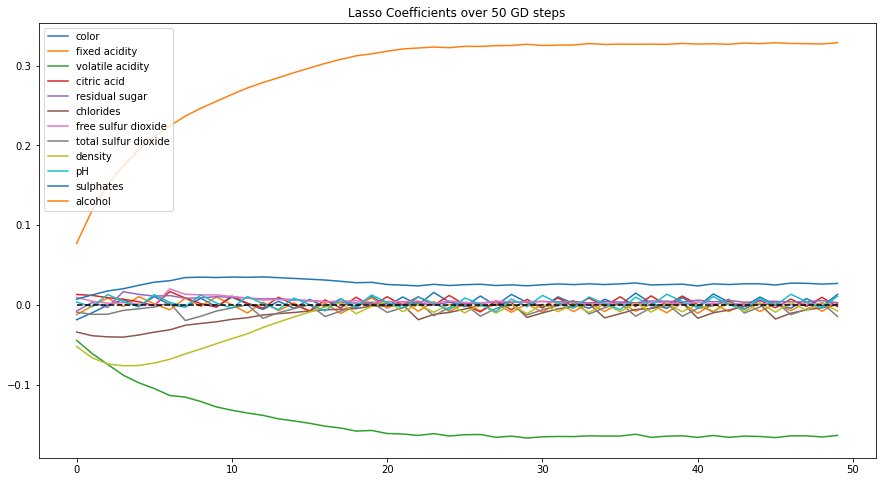

None

In [113]:
plotCoeffs(lasso_models, ['Bias'] + FIELDS, "Lasso Coefficients over 50 GD steps")

In the three plots above, we see how the coefficients change for each feature in our model across 50 steps of gradient descent. We see that in the ridge regression model, looks similar to the standard ols regression, but perhaps they are stabilizing a little bit faster. The big difference comes when we compare to the lasso regression model. In the lasso regression model, we see that the coefficients for many features are deemed insignificant early on and are kept close to zero.

## Compare Performance of the Three Methods

In this section, we compare the performance of the models (in terms of MSE) on the heldout dataset.

In [119]:
best_ols = models[49]
best_ridge = ridge_models[49]
best_lasso = lasso_models[49]

In [120]:
olsMSE, ridgeMSE, lassoMSE = None, None, None
validationRDD = None
validationRDD = normalize(heldOutRDD.map(parse)).cache()

olsMSE = OLSLoss(validationRDD,best_ols)
ridgeMSE = OLSLoss(validationRDD,best_ridge)
lassoMSE = OLSLoss(validationRDD,best_lasso)

print(f"OLS Mean Squared Error: {olsMSE}")
print(f"Ridge Mean Squared Error: {ridgeMSE}")
print(f"Lasso Mean Squared Error: {lassoMSE}")

OLS Mean Squared Error: 0.5528930634616994
Ridge Mean Squared Error: 0.557053078585076
Lasso Mean Squared Error: 0.5794781870785186


Here we see that lasso regression performs the worst on the held out dataset. However, it uses much fewer variables so that is a tradeoff worth noting. Normally, we would expect ridge or lasso regression to generalize better since that is our goal with regularization. Perhaps some hyper-parameters need to be tuned for that to be the case. Or perhaps, the held out data set was very similar to the data that we trained on. 